In [17]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score, KFold
from cm import plot_confusion_matrix
import pickle

### Prep Training Data

In [18]:
# bring in the participants data
participants_train = pd.read_csv('../data/participants_train.csv')

# bring in the champion_mastery info
champion_mastery = pd.read_csv('../data/champion_mastery.csv')

# merge champion mastery info in
df = pd.merge(participants_train, champion_mastery, on = ['championId', 'summonerId'])

# bring in stats data from the 10-minute mark
stats = pd.read_pickle('../data/ten_min_stats.pkl')#.drop(columns = 'Unnamed: 0')

# merge in stats
df = (
    pd.merge(df, 
             stats, 
             on = ['matchId', 'participantId'])
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78269 entries, 0 to 78268
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   matchId         78269 non-null  int64 
 1   teamId          78269 non-null  int64 
 2   participantId   78269 non-null  int64 
 3   summonerId      78269 non-null  int64 
 4   summonerLevel   78269 non-null  int64 
 5   championName    78269 non-null  object
 6   championId      78269 non-null  int64 
 7   championLevel   78269 non-null  int64 
 8   championPoints  78269 non-null  int64 
 9   chestGranted    78269 non-null  bool  
 10  tokensEarned    78269 non-null  int64 
 11  total_gold      78269 non-null  int64 
 12  xp              78269 non-null  int64 
 13  level           78269 non-null  int64 
 14  position        78269 non-null  object
 15  champ_stats     78269 non-null  object
 16  damage_stats    78269 non-null  object
 17  timestamp       78269 non-null  int64 
dtypes: boo

In [19]:
# aggregate team stats
team_stats = (
    df
    .groupby(['matchId', 'teamId'])
    .agg(champion_level = ('championLevel', 'sum'),
         champion_points = ('championPoints', 'sum'),
         total_gold = ('total_gold', 'sum'),
         total_xp = ('xp', 'sum'),
         avg_level = ('level', 'mean'),
         participants = ('participantId', 'count'))
    .reset_index()
)

In [20]:
# check for any teams that are missing participants due to missing data/merging
team_stats.loc[team_stats['participants'] != 5]

,matchId,teamId,champion_level,champion_points,total_gold,total_xp,avg_level,participants
3940,2014,100,24,2913158,17230,13816,7.0,4


In [21]:
# pull out the match with a missing participant, clean up table
team_stats = team_stats.loc[team_stats['matchId'] != 2014].drop(columns = 'participants')

team_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15652 entries, 0 to 15653
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   matchId          15652 non-null  int64  
 1   teamId           15652 non-null  int64  
 2   champion_level   15652 non-null  int64  
 3   champion_points  15652 non-null  int64  
 4   total_gold       15652 non-null  int64  
 5   total_xp         15652 non-null  int64  
 6   avg_level        15652 non-null  float64
dtypes: float64(1), int64(6)
memory usage: 978.2 KB


In [22]:
# separate out the teams for each match so they can be put into the same row
team_100s = team_stats.loc[team_stats['teamId'] == 100].reset_index(drop = True)

team_200s = team_stats.loc[team_stats['teamId'] == 200].reset_index(drop = True)

# merge so that data for both teams is horizontally arranged
model_df = pd.merge(team_100s, team_200s, on = 'matchId', suffixes = ('_100', '_200'))

#bring in and merge the winners data
winners = pd.read_csv('../data/train_winners.csv')

model_df = pd.merge(model_df,
                    winners, 
                    how = 'left',
                    on = 'matchId')

model_df

,matchId,teamId_100,champion_level_100,champion_points_100,total_gold_100,total_xp_100,avg_level_100,teamId_200,champion_level_200,champion_points_200,total_gold_200,total_xp_200,avg_level_200,winner
0,0,100,30,844882,14146,17159,6.8,200,30,1450310,17539,18773,7.0,200
1,1,100,33,2227610,17662,17770,6.8,200,25,871583,14816,18028,6.8,200
2,2,100,25,391340,16374,16837,6.4,200,24,665251,17347,17467,6.8,200
3,3,100,28,640810,19247,17562,6.8,200,31,928477,15145,16196,6.4,100
4,4,100,28,645519,16776,18264,7.2,200,21,141851,15385,17194,6.6,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7821,7995,100,30,1243322,19009,18803,7.2,200,30,1411140,14873,16977,6.8,200
7822,7996,100,28,1301721,16413,17298,6.6,200,30,557302,16140,17927,6.8,100
7823,7997,100,29,664485,17745,17090,6.8,200,29,1203774,16571,15721,6.6,200
7824,7998,100,26,290251,15543,15853,6.4,200,32,703659,18311,18654,7.2,200


### Build the model

- Use total champion level, total gold, and total xp for each team

In [23]:
variables = ['champion_level_100', 'total_gold_100', 'total_xp_100',
             'champion_level_200','total_gold_200', 'total_xp_200']

X = model_df[variables]

y = model_df['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)

logreg1 = LogisticRegression().fit(X_train, y_train)

In [24]:
logreg1.predict_proba(X_test)

array([[0.20531841, 0.79468159],
       [0.85989574, 0.14010426],
       [0.26722605, 0.73277395],
       ...,
       [0.20009581, 0.79990419],
       [0.18886142, 0.81113858],
       [0.67547496, 0.32452504]])

In [25]:
X_test.assign(prob_100 = logreg1.predict_proba(X_test)[:,0],
              prob_200 = logreg1.predict_proba(X_test)[:,1],
              prediction = logreg1.predict(X_test),
              true = y_test)

,champion_level_100,total_gold_100,total_xp_100,champion_level_200,total_gold_200,total_xp_200,prob_100,prob_200,prediction,true
2555,20,14612,16968,32,15990,18204,0.205318,0.794682,200,200
6815,28,16544,18102,26,13254,16725,0.859896,0.140104,100,100
799,25,16744,16143,28,18281,17560,0.267226,0.732774,200,200
4777,29,16795,18448,30,13688,18083,0.808635,0.191365,100,200
7209,29,14491,15139,30,17782,17348,0.138494,0.861506,200,200
...,...,...,...,...,...,...,...,...,...,...
1665,30,19099,17930,27,17464,17852,0.719432,0.280568,100,200
2321,30,13457,17389,20,17249,18633,0.182356,0.817644,200,100
5569,32,13479,16715,26,16535,18455,0.200096,0.799904,200,200
1913,24,14449,16817,26,16913,18352,0.188861,0.811139,200,200


In [26]:
print(classification_report(y_test, logreg1.predict(X_test)))

              precision    recall  f1-score   support

         100       0.70      0.72      0.71       995
         200       0.70      0.69      0.70       962

    accuracy                           0.70      1957
   macro avg       0.70      0.70      0.70      1957
weighted avg       0.70      0.70      0.70      1957



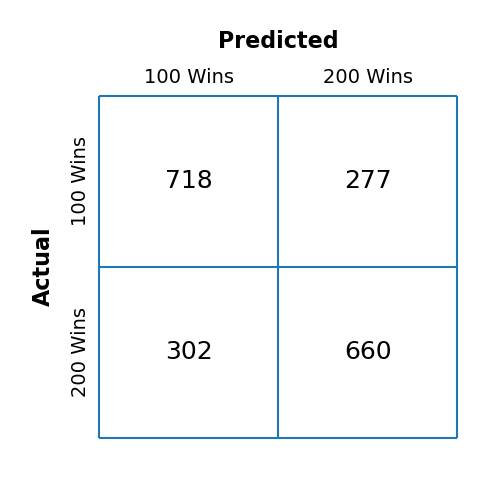

In [27]:
plot_confusion_matrix(y_test, logreg1.predict(X_test), labels = ['100 Wins', '200 Wins']);

In [28]:
accuracy_score(y_test, logreg1.predict(X_test))

0.7041389882473174

In [29]:
import matplotlib.pyplot as plt

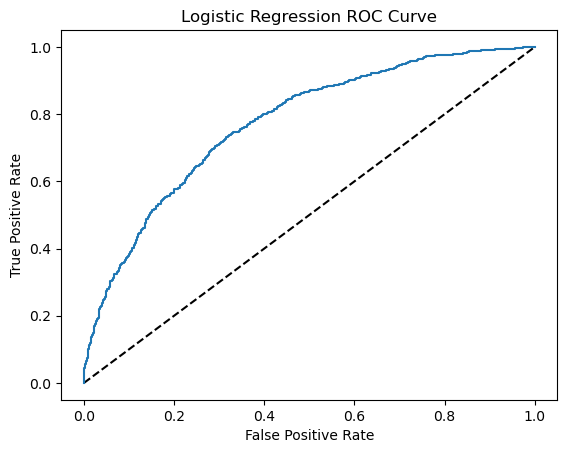

In [30]:
y_pred_probs = logreg1.predict_proba(X_test)[:, 1]
tf_y_test = y_test == 200

fpr, tpr, thresholds = roc_curve(tf_y_test, y_pred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

- Swap champion points out for champion level

In [31]:
variables = ['champion_points_100', 'total_gold_100', 'total_xp_100',
             'champion_points_200', 'total_gold_200', 'total_xp_200']

X = model_df[variables]

y = model_df['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)

logreg2 = LogisticRegression().fit(X_train, y_train)

In [32]:
logreg2.predict_proba(X_test)

array([[0.30877922, 0.69122078],
       [0.8525148 , 0.1474852 ],
       [0.28161691, 0.71838309],
       ...,
       [0.16616901, 0.83383099],
       [0.20800988, 0.79199012],
       [0.68860271, 0.31139729]])

In [33]:
print(classification_report(y_test, logreg2.predict(X_test)))

              precision    recall  f1-score   support

         100       0.70      0.72      0.71       995
         200       0.70      0.68      0.69       962

    accuracy                           0.70      1957
   macro avg       0.70      0.70      0.70      1957
weighted avg       0.70      0.70      0.70      1957



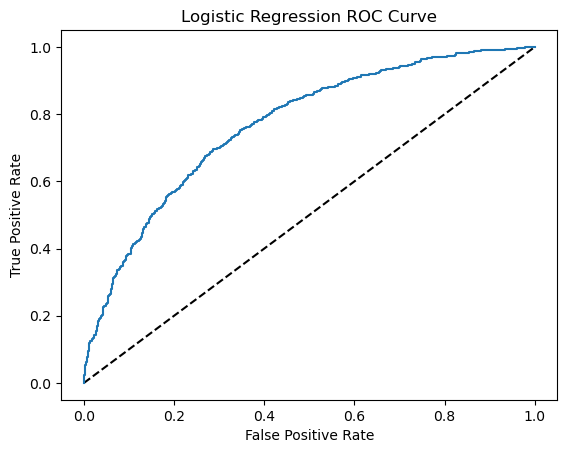

In [34]:
y_pred_probs = logreg2.predict_proba(X_test)[:, 1]
tf_y_test = y_test == 200

fpr, tpr, thresholds = roc_curve(tf_y_test, y_pred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

The first one has slightly better F1 and Recall values, so that's what we'll fit to the model

### Get preditions using test data

In [37]:
# bring in the participants data
participants_test = pd.read_csv('../data/participants_test.csv')

# bring in the champion_mastery info
champion_mastery = pd.read_csv('../data/champion_mastery.csv')

# merge champion mastery info in
df = pd.merge(participants_test, champion_mastery, on = ['championId', 'summonerId'])

# bring in stats data from the 10-minute mark
stats = pd.read_csv('../data/test_ten_min_stats.pkl').drop(columns = 'Unnamed: 0')

# merge in stats
df = (
    pd.merge(df, 
             stats, 
             on = ['matchId', 'participantId'])
)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [ ]:
# aggregate team stats
test_team_stats = (
    df
    .groupby(['matchId', 'teamId'])
    .agg(champion_level = ('championLevel', 'sum'),
         champion_points = ('championPoints', 'sum'),
         total_gold = ('total_gold', 'sum'),
         total_xp = ('xp', 'sum'),
         avg_level = ('level', 'mean'),
         participants = ('participantId', 'count'))
    .reset_index()
)

In [ ]:
# separate out the teams for each match so they can be put into the same row
test_team_100s = test_team_stats.loc[test_team_stats['teamId'] == 100].reset_index(drop = True)

test_team_200s = test_team_stats.loc[test_team_stats['teamId'] == 200].reset_index(drop = True)

# merge so that data for both teams is horizontally arranged
test_model_df = pd.merge(test_team_100s, test_team_200s, on = 'matchId', suffixes = ('_100', '_200'))

test_model_df

In [ ]:
variables = ['champion_level_100', 'total_gold_100', 'total_xp_100',
             'champion_level_200','total_gold_200', 'total_xp_200']

test_X = test_model_df[variables]

submission_predictions = pd.DataFrame(logreg1.predict(test_X)).rename(columns = {0 : 'winner'})

In [ ]:
submission = pd.merge(test_model_df['matchId'], submission_predictions, left_index = True, right_index = True )
submission

In [ ]:
submission.to_csv('../data/submission_2023-28-03_v01.csv', index = False)